# Congruence via Dentritic Density

In this notebook, we try to calculate candidate node similarity via a simpler computational method than N-Degree Relations. We take a list of candidate entities, represented as Item IDs, and search for that Item ID in either `source_item_id` or `target_item_id` in `statements_df`. This guarantees one layer of surrounding graph from the candidates, the potential for overlap and lets us measure candidate node importance via "Density" (number of first degree connections) or "Connectivity" (number of dendritic connections between candidate nodes).

#### Import Packages

In [1]:
import os
import time
import re

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Progress bar
from tqdm import tqdm

## Integrate Predictions

In [2]:
# Base path to input
preds_path = '../../predictions/'

# Load data
entity_disambiguation = pd.read_csv(os.path.join(preds_path, "wikipedia2vec_most_similar.csv"), delimiter=",")
entity_disambiguation.head(10)

,mention,full_mention,wikipedia_URL,wikipedia_ID,wikipedia_title,sentence_id,doc_id,congruent_mentions,preds_w2v_getentity,full_mention_norm,preds_w2v_mostsimilar,score_w2v_mostsimilar,candidate_pool_mostsimilar,candidate_scores_mostsimilar
0,B,EU,NaN,NaN,NaN,0,0,"['EU', 'German', 'British']",European Union,eu,European Union,0.787421,"['European Union', 'European Free Trade Associ...","[0.7874206, 0.7662648, 0.76082164, 0.76052165,..."
1,B,German,http://en.wikipedia.org/wiki/Germany,11867.0,Germany,0,0,"['EU', 'German', 'British']",NaN,german,Culture of Germany,0.686803,"['Culture of Germany', '1860 in Germany', '186...","[0.68680257, 0.6840672, 0.6836185, 0.68068546,..."
2,B,British,http://en.wikipedia.org/wiki/United_Kingdom,31717.0,United Kingdom,0,0,"['EU', 'German', 'British']",NaN,british,Russians in the United Kingdom,0.615564,"['Russians in the United Kingdom', 'Henry Wood...","[0.6155642, 0.60587233, 0.6025652, 0.5973172, ..."
3,B,Peter Blackburn,NaN,NaN,NaN,1,0,"['Peter Blackburn', 'BRUSSELS', 'European Comm...",NaN,peter blackburn,Russians in the United Kingdom,0.615564,[],[]
4,I,Peter Blackburn,NaN,NaN,NaN,1,0,"['Peter Blackburn', 'BRUSSELS', 'European Comm...",NaN,peter blackburn,Russians in the United Kingdom,0.615564,[],[]
5,B,BRUSSELS,http://en.wikipedia.org/wiki/Brussels,3708.0,Brussels,1,0,"['Peter Blackburn', 'BRUSSELS', 'European Comm...",NaN,brussels,Brussels,0.887070,"['Brussels', 'Ghent', 'Timeline of Brussels', ...","[0.8870699, 0.7689268, 0.76867557, 0.7681168, ..."
6,B,European Commission,http://en.wikipedia.org/wiki/European_Commission,9974.0,European Commission,1,0,"['Peter Blackburn', 'BRUSSELS', 'European Comm...",European Commission,european commission,Brussels,0.887070,[],[]
7,I,European Commission,http://en.wikipedia.org/wiki/European_Commission,9974.0,European Commission,1,0,"['Peter Blackburn', 'BRUSSELS', 'European Comm...",European Commission,european commission,Brussels,0.887070,[],[]
8,B,German,http://en.wikipedia.org/wiki/Germany,11867.0,Germany,1,0,"['Peter Blackburn', 'BRUSSELS', 'European Comm...",NaN,german,Culture of Germany,0.686803,"['Culture of Germany', '1860 in Germany', '186...","[0.68680257, 0.6840672, 0.6836185, 0.68068546,..."
9,B,British,http://en.wikipedia.org/wiki/United_Kingdom,31717.0,United Kingdom,1,0,"['Peter Blackburn', 'BRUSSELS', 'European Comm...",NaN,british,Russians in the United Kingdom,0.615564,"['Russians in the United Kingdom', 'Henry Wood...","[0.6155642, 0.60587233, 0.6025652, 0.5973172, ..."


In [3]:
# Confirm length
len(entity_disambiguation)

1000

### Parse Saved Candidate Pool

Candidate pools when exported are typically stored as the string of a list. The below function parses the string back into a list with proper formatted values.

In [4]:
# Example
entity_disambiguation['candidate_pool_mostsimilar'][0][2:-2].split("', '")

['European Union',
 'European Free Trade Association',
 'European Economic Area',
 'European Union legislative procedure#Codecision procedure',
 'Directorate-General for Trade',
 'European Union Operations Centre',
 'Development Cooperation Instrument',
 'European Common Aviation Area',
 'European Political Strategy Centre',
 'European Union Global Strategy',
 'Treaties of the European Union',
 'European Defence Fund',
 'Bodies of the European Union',
 'Common commercial policy',
 'Common Foreign and Security Policy\', "European Union\'s scientific cooperation beyond the bloc", \'Small Business Act for Europe',
 'Committee of Permanent Representatives',
 'Treaties of the European Union#Treaty on the functioning of the European Union',
 'Lists of member states of the European Union',
 'Free trade areas in Europe#BAFTA',
 'Member state of the European Union',
 'Acquis communautaire',
 'Directorate-General for External Relations (European Commission)',
 'Directorate-General for Financial 

In [5]:
# Function to parse list as string
def parse_w2v_list(list_string):
    
    parsed_list = []
    
    # If candidate pool is empty
    if list_string == "[]":
        pass
    # Else parse
    else:
        # Eliminate bracket and parenthesis on either side, split by comma pattern
        parsed_list = re.split("', '|\", \"|', \"|\", \'", list_string[2:-2])
        
    return parsed_list


In [6]:
# Manually test function
# 0 is the hard one. See how some value is stored with '' and some with "". Unsure why.
parse_w2v_list(entity_disambiguation['candidate_pool_mostsimilar'][0])

['European Union',
 'European Free Trade Association',
 'European Economic Area',
 'European Union legislative procedure#Codecision procedure',
 'Directorate-General for Trade',
 'European Union Operations Centre',
 'Development Cooperation Instrument',
 'European Common Aviation Area',
 'European Political Strategy Centre',
 'European Union Global Strategy',
 'Treaties of the European Union',
 'European Defence Fund',
 'Bodies of the European Union',
 'Common commercial policy',
 'Common Foreign and Security Policy',
 "European Union's scientific cooperation beyond the bloc",
 'Small Business Act for Europe',
 'Committee of Permanent Representatives',
 'Treaties of the European Union#Treaty on the functioning of the European Union',
 'Lists of member states of the European Union',
 'Free trade areas in Europe#BAFTA',
 'Member state of the European Union',
 'Acquis communautaire',
 'Directorate-General for External Relations (European Commission)',
 'Directorate-General for Financial S

In [7]:
# Apply defined function
parsed_candidate_pool = entity_disambiguation['candidate_pool_mostsimilar'].apply(parse_w2v_list)
entity_disambiguation['candidate_pool_mostsimilar'] = parsed_candidate_pool
entity_disambiguation['candidate_pool_mostsimilar'][:3]

0    [European Union, European Free Trade Associati...
1    [Culture of Germany, 1860 in Germany, 1866 in ...
2    [Russians in the United Kingdom, Henry Wood (n...
Name: candidate_pool_mostsimilar, dtype: object

In [8]:
# Integrate page.csv
page_df = pd.read_csv("../../data/kdkg/page.csv", delimiter=',')
assert type(page_df) is not None
display(page_df.head(3))

,page_id,item_id,title,views
0,12,6199,Anarchism,31335
1,25,38404,Autism,49693
2,39,101038,Albedo,14573


In [9]:
# Test manual search
page_df[page_df['title'] == "Russians in the United Kingdom"]

,page_id,item_id,title,views
1352883,9808786,3308075,Russians in the United Kingdom,684


### Get Item IDs

In [10]:
# Define function to take Wikipedia page title and return Wikipedia Item ID and Page ID (todo)
# Using page_df, not item_df
def get_item_id(page_title):
        
    # Retrieve item id from page_df
    try:
        item_id = page_df[page_df['title'] == page_title]['item_id'].values[0]
    #     page_id = page_df[page_df['title'] == page_title]['page_id']
    except IndexError:
        item_id = None
        
    return item_id # todo is there any reason to return page_id?

In [12]:
# Run over whole dataframe
candidate_pool_ids = []
no_id_match = 0
query_count = 0
for i in tqdm(range(len(entity_disambiguation))):
    pool = []
    candidates = entity_disambiguation['candidate_pool_mostsimilar'][i]
    for l in candidates:
        item_id = get_item_id(l)
        pool.append(item_id)
        if item_id is None:
            no_id_match += 1
        query_count += 1
    candidate_pool_ids.append(pool)

print("Unable to match known page title with page id: ", round(no_id_match/query_count*100,3),"%")

100%|██████████| 1000/1000 [17:48<00:00,  1.07s/it]

Unable to match known page title with page id:  17.292 %


In [18]:
entity_disambiguation['candidate_pool_ids'] = candidate_pool_ids
entity_disambiguation.head(3)

,mention,full_mention,wikipedia_URL,wikipedia_ID,wikipedia_title,sentence_id,doc_id,congruent_mentions,preds_w2v_getentity,full_mention_norm,preds_w2v_mostsimilar,score_w2v_mostsimilar,candidate_pool_mostsimilar,candidate_scores_mostsimilar,candidate_pool_ids
0,B,EU,NaN,NaN,NaN,0,0,"['EU', 'German', 'British']",European Union,eu,European Union,0.787421,"[European Union, European Free Trade Associati...","[0.7874206, 0.7662648, 0.76082164, 0.76052165,...","[458, 166546, 8932, None, 1501745, 48739380, 5..."
1,B,German,http://en.wikipedia.org/wiki/Germany,11867.0,Germany,0,0,"['EU', 'German', 'British']",NaN,german,Culture of Germany,0.686803,"[Culture of Germany, 1860 in Germany, 1866 in ...","[0.68680257, 0.6840672, 0.6836185, 0.68068546,...","[1979615, 56291039, None, None, None, None, None]"
2,B,British,http://en.wikipedia.org/wiki/United_Kingdom,31717.0,United Kingdom,0,0,"['EU', 'German', 'British']",NaN,british,Russians in the United Kingdom,0.615564,"[Russians in the United Kingdom, Henry Wood (n...","[0.6155642, 0.60587233, 0.6025652, 0.5973172, ...","[3308075, None, None, None, 7785]"


# Generate Graph of Dendrites

From this pool of candidate IDs, we are going to generate our one-degree in both direction dendritic graph from `statements.csv`.

In [13]:
# Integrate statements.csv
statements_df = pd.read_csv("../../data/kdkg/statements.csv", delimiter=',')
assert type(statements_df) is not None
display(statements_df.head(3))

,source_item_id,edge_property_id,target_item_id
0,1,31,36906466
1,1,279,3695190
2,1,398,497745


In [15]:
# How many sentences exist in our data
sentence_count = max(entity_disambiguation['sentence_id'])
print("{:,} sentences in our data.".format(sentence_count))

221 sentences in our data.


In [172]:
%%time
# Manually test on one candidate pool
rand_idx = np.random.randint(len(entity_disambiguation))
print("Generating Values for {}".format(entity_disambiguation['full_mention'][rand_idx]))
candidate_pool = entity_disambiguation['candidate_pool_ids'][rand_idx]
candidate_pool_dendrites = statements_df[statements_df['source_item_id'].isin(candidate_pool)\
             | statements_df['target_item_id'].isin(candidate_pool)]
display(candidate_pool_dendrites)

Generating Values for Xinhua


,source_item_id,edge_property_id,target_item_id
365048,17427,1830,851422
1048265,72877,150,1197024
2349691,198264,19,42956
2349692,198264,21,6581097
2349693,198264,27,148
...,...,...,...
68167593,24034788,108,204839
89354639,36980916,1889,851422
107902754,49865550,301,969272
118490013,58032242,921,851422


CPU times: user 3.95 s, sys: 1.44 s, total: 5.39 s
Wall time: 5.41 s


## Create Dendritic Graph using NetworkX

In [21]:
# import NetworkX
import networkx as nx

In [173]:
%%time
# Create NX graph from Pandas dataframe
G = nx.from_pandas_edgelist(candidate_pool_dendrites,
                           source='source_item_id', target='target_item_id',
                           edge_attr=True, create_using=nx.MultiGraph())

CPU times: user 934 µs, sys: 15 µs, total: 949 µs
Wall time: 954 µs


In [174]:
# Print number of nodes in graph
print("Number of nodes: ", G.number_of_nodes())
print("Number of links: ", G.number_of_edges())

Number of nodes:  69
Number of links:  103


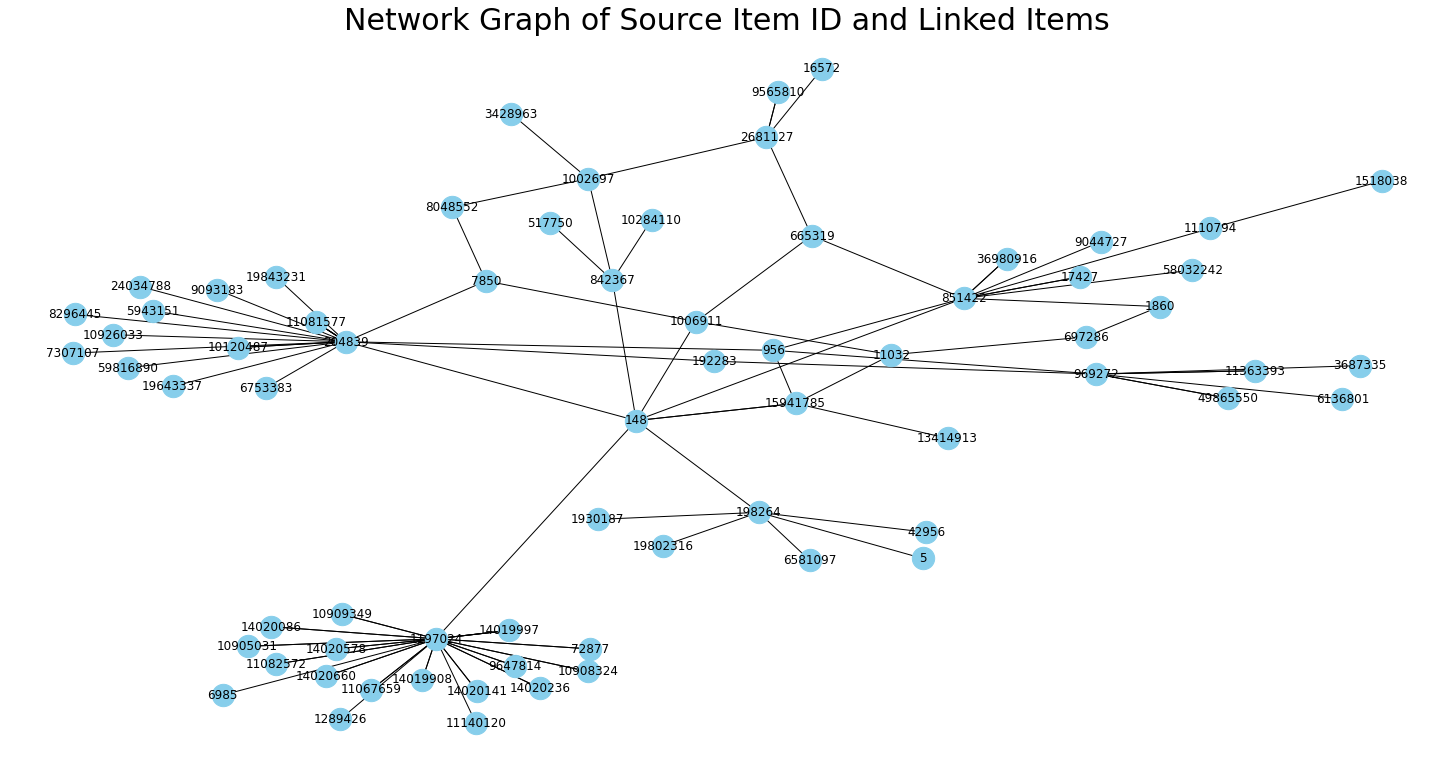

CPU times: user 301 ms, sys: 53.7 ms, total: 355 ms
Wall time: 354 ms


In [175]:
%%time
# Display filtered network graph for our source page
plt.figure(figsize=(20,10))
pos = nx.spring_layout(G, k = 0.1) # k regulates the distance between nodes
nx.draw(G, with_labels=True, node_color='skyblue', node_size=500, edge_cmap=plt.cm.Blues, pos=pos)
plt.title("Network Graph of Source Item ID and Linked Items", size=30)
plt.show()

### Create Distance Matrix

By taking every candidate and computing the distance to every other candidate, we can create a distance matrix showing which nodes (if any) are closer to each other. We will then select the most connected or closest connected node from the candidate pool as the predicted entity.

In [176]:
print("Matrix will be of size {}x{}".format(len(candidate_pool), len(candidate_pool)))

Matrix will be of size 14x14


In [177]:
%%time
# Iteratively create matrix
shortest_path_matrix = []
for candidate_src in candidate_pool:
    shortest_paths = []
#     print("Source: ", candidate_src)
    for candidate_trgt in candidate_pool:
#         print("Target: ", candidate_trgt)
        if candidate_src is None or candidate_trgt is None:
            shortest_paths.append(None)
        else:
            try:
                shortest_paths.append(int(nx.shortest_path_length(G, source=candidate_src, target=candidate_trgt)))
            except:
                shortest_paths.append(-1)
    shortest_path_matrix.append(shortest_paths)

CPU times: user 2.41 ms, sys: 3 µs, total: 2.41 ms
Wall time: 2.41 ms


In [178]:
# Display matrix with closest nodes highlighted
shortest_path_df = pd.DataFrame(shortest_path_matrix)
shortest_path_df.style.apply(lambda x: ["background: skyblue" if v == 1 else "" for v in x], axis = 1)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,0,2,2,2,2,2,2,-1,2,2,4,4,4,4
1,2,0,4,2,4,2,4,-1,4,4,4,4,6,4
2,2,4,0,2,2,2,2,-1,2,2,2,4,4,2
3,2,2,2,0,2,2,2,-1,4,2,4,4,4,2
4,2,4,2,2,0,2,2,-1,2,2,2,4,2,4
5,2,2,2,2,2,0,2,-1,4,2,2,2,4,2
6,2,4,2,2,2,2,0,-1,4,2,4,4,4,4
7,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
8,2,4,2,4,2,4,4,-1,0,4,2,6,2,4
9,2,4,2,2,2,2,2,-1,4,0,4,4,4,4


In [179]:
# Count node closest to other nodes
rank_by_count_of_close = np.sum(shortest_path_df[shortest_path_df == 1], axis=0).sort_values(ascending=False)
display(rank_by_count_of_close)
prediction_by_count_rank = rank_by_count_of_close.index[0]
print("Prediction would be {}".format(page_df[page_df['item_id'] == candidate_pool[prediction_by_count_rank]]['title'].values))

13    0.0
12    0.0
11    0.0
10    0.0
9     0.0
8     0.0
7     0.0
6     0.0
5     0.0
4     0.0
3     0.0
2     0.0
1     0.0
0     0.0
dtype: float64

Prediction would be ['Taiwan News']


In [180]:
# Count node with lowest average distance
rank_by_mean_path = np.mean(shortest_path_df, axis=0).sort_values(ascending=True)
display(rank_by_mean_path)
# Filter out -1 values representing no path
prediction_by_mean_rank = rank_by_mean_path[rank_by_mean_path >= 0].index[0]
print("Prediction would be {}".format(page_df[page_df['item_id'] == candidate_pool[prediction_by_mean_rank]]['title'].values))

7    -1.000000
5     1.928571
2     2.071429
4     2.071429
0     2.214286
3     2.214286
6     2.500000
9     2.500000
10    2.642857
8     2.785714
1     3.071429
13    3.071429
12    3.357143
11    3.500000
dtype: float64

Prediction would be ['China Daily']
